In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Study population

In [2]:
data_dir = '../datafiles/chexpert/'
df_demo = pd.DataFrame(pd.read_excel(data_dir + 'CHEXPERT_DEMO.xlsx', engine='openpyxl'))

df_demo = df_demo.rename(columns={'PRIMARY_RACE': 'race'})
df_demo = df_demo.rename(columns={'PATIENT': 'patient_id'})
df_demo = df_demo.rename(columns={'GENDER': 'sex'})
df_demo = df_demo.rename(columns={'AGE_AT_CXR': 'age'})
df_demo = df_demo.rename(columns={'ETHNICITY': 'ethnicity'})
df_demo = df_demo.drop(['sex', 'age'], axis=1)
df_demo.head()

,patient_id,race,ethnicity
0,patient24428,White,Non-Hispanic/Non-Latino
1,patient48289,Other,Hispanic/Latino
2,patient33856,White,Non-Hispanic/Non-Latino
3,patient41673,Unknown,Unknown
4,patient48493,White,Non-Hispanic/Non-Latino


In [3]:
df_data_split = pd.read_csv(data_dir + 'chexpert_split_2021_08_20.csv').set_index('index')

df_img_data = pd.read_csv(data_dir + 'train_cheXbert.csv')

df_img_data = pd.concat([df_img_data,df_data_split], axis=1)
df_img_data = df_img_data[~df_img_data.split.isna()]

split =  df_img_data.Path.str.split("/", expand = True)
df_img_data["patient_id"] = split[2]
df_img_data = df_img_data.rename(columns={'Age': 'age'})
df_img_data = df_img_data.rename(columns={'Sex': 'sex'})
df_img_data.head()

,Path,sex,age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,...,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding,Unnamed: 0,split,patient_id
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,NaN,1.0,1.0,NaN,-1.0,...,-1.0,NaN,-1.0,NaN,1.0,NaN,NaN,0.0,train,patient00002
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,train,patient00002
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,1.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.0,train,patient00003
5,CheXpert-v1.0/train/patient00004/study1/view1_...,Female,20,Frontal,PA,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,3.0,train,patient00004
7,CheXpert-v1.0/train/patient00005/study1/view1_...,Male,33,Frontal,PA,1.0,0.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,1.0,1.0,4.0,train,patient00005


In [4]:
df_cxr = df_demo.merge(df_img_data, on="patient_id")
df_cxr.head()

,patient_id,race,ethnicity,Path,sex,age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,...,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding,Unnamed: 0,split
0,patient24428,White,Non-Hispanic/Non-Latino,CheXpert-v1.0/train/patient24428/study22/view1...,Male,59,Frontal,AP,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,53688.0,train
1,patient24428,White,Non-Hispanic/Non-Latino,CheXpert-v1.0/train/patient24428/study39/view1...,Male,61,Frontal,PA,NaN,NaN,...,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,53689.0,train
2,patient24428,White,Non-Hispanic/Non-Latino,CheXpert-v1.0/train/patient24428/study61/view1...,Male,61,Frontal,AP,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,53690.0,train
3,patient24428,White,Non-Hispanic/Non-Latino,CheXpert-v1.0/train/patient24428/study35/view1...,Male,60,Frontal,AP,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,53691.0,train
4,patient24428,White,Non-Hispanic/Non-Latino,CheXpert-v1.0/train/patient24428/study45/view1...,Male,61,Frontal,AP,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,53692.0,train


In [5]:
white = 'White'
asian = 'Asian'
black = 'Black'

In [6]:
mask = (df_cxr.race.str.contains("Black", na=False))
df_cxr.loc[mask, "race"] = black

mask = (df_cxr.race.str.contains("White", na=False))
df_cxr.loc[mask, "race"] = white

mask = (df_cxr.race.str.contains("Asian", na=False))
df_cxr.loc[mask, "race"] = asian

df_cxr['race'].unique()

array(['White', 'Asian', 'Black'], dtype=object)

In [7]:
df_cxr = df_cxr[df_cxr.race.isin([asian,black,white])]

In [8]:
df_cxr = df_cxr[df_cxr.ethnicity.isin(["Non-Hispanic/Non-Latino","Not Hispanic"])]

In [9]:
df_cxr = df_cxr[df_cxr["Frontal/Lateral"]=="Frontal"]

In [10]:
df_cxr['race_label'] = df_cxr['race']

df_cxr.loc[df_cxr['race_label'] == white, 'race_label'] = 0
df_cxr.loc[df_cxr['race_label'] == asian, 'race_label'] = 1
df_cxr.loc[df_cxr['race_label'] == black, 'race_label'] = 2

In [11]:
df_cxr['sex_label'] = df_cxr['sex']

df_cxr.loc[df_cxr['sex_label'] == 'Male', 'sex_label'] = 0
df_cxr.loc[df_cxr['sex_label'] == 'Female', 'sex_label'] = 1

In [12]:
labels = [
    'No Finding',
    'Enlarged Cardiomediastinum',
    'Cardiomegaly',
    'Lung Opacity',
    'Lung Lesion',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices']

In [13]:
df_cxr['disease'] = df_cxr[labels[0]]
df_cxr.loc[df_cxr[labels[0]] == 1, 'disease'] = labels[0]
df_cxr.loc[df_cxr[labels[10]] == 1, 'disease'] = labels[10]
df_cxr.loc[df_cxr['disease'].isna(), 'disease'] = 'Other'

df_cxr['disease_label'] = df_cxr['disease']
df_cxr.loc[df_cxr['disease_label'] == labels[0], 'disease_label'] = 0
df_cxr.loc[df_cxr['disease_label'] == labels[10], 'disease_label'] = 1
df_cxr.loc[df_cxr['disease_label'] == 'Other', 'disease_label'] = 2

# Pre-processing of imaging dataset (this may take a few hours, needed only once)

In [14]:
# point to the parent directory that contains the folder 'CheXpert-v1.0'
img_data_dir = '../../'

In [15]:
df_cxr

,patient_id,race,ethnicity,Path,sex,age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,...,Pleural Other,Fracture,Support Devices,No Finding,Unnamed: 0,split,race_label,sex_label,disease,disease_label
0,patient24428,White,Non-Hispanic/Non-Latino,CheXpert-v1.0/train/patient24428/study22/view1...,Male,59,Frontal,AP,NaN,NaN,...,NaN,NaN,1.0,NaN,53688.0,train,0,0,Other,2
1,patient24428,White,Non-Hispanic/Non-Latino,CheXpert-v1.0/train/patient24428/study39/view1...,Male,61,Frontal,PA,NaN,NaN,...,NaN,NaN,NaN,NaN,53689.0,train,0,0,Other,2
2,patient24428,White,Non-Hispanic/Non-Latino,CheXpert-v1.0/train/patient24428/study61/view1...,Male,61,Frontal,AP,NaN,NaN,...,NaN,NaN,1.0,NaN,53690.0,train,0,0,Pleural Effusion,1
3,patient24428,White,Non-Hispanic/Non-Latino,CheXpert-v1.0/train/patient24428/study35/view1...,Male,60,Frontal,AP,NaN,NaN,...,NaN,NaN,1.0,NaN,53691.0,train,0,0,Other,2
4,patient24428,White,Non-Hispanic/Non-Latino,CheXpert-v1.0/train/patient24428/study45/view1...,Male,61,Frontal,AP,NaN,NaN,...,NaN,NaN,1.0,NaN,53692.0,train,0,0,Pleural Effusion,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127113,patient02799,White,Non-Hispanic/Non-Latino,CheXpert-v1.0/train/patient02799/study1/view1_...,Male,40,Frontal,AP,NaN,NaN,...,NaN,NaN,1.0,1.0,6110.0,test,0,0,No Finding,0
127114,patient22486,Asian,Non-Hispanic/Non-Latino,CheXpert-v1.0/train/patient22486/study1/view1_...,Male,52,Frontal,AP,NaN,NaN,...,NaN,NaN,NaN,NaN,49372.0,test,1,0,Pleural Effusion,1
127115,patient05143,White,Non-Hispanic/Non-Latino,CheXpert-v1.0/train/patient05143/study3/view1_...,Male,24,Frontal,PA,1.0,-1.0,...,NaN,NaN,1.0,NaN,11138.0,test,0,0,Other,2
127116,patient05143,White,Non-Hispanic/Non-Latino,CheXpert-v1.0/train/patient05143/study1/view1_...,Male,24,Frontal,AP,NaN,0.0,...,NaN,NaN,1.0,1.0,11139.0,test,0,0,No Finding,0


In [16]:
# from skimage.io import imread
# from skimage.io import imsave
# from skimage.transform import resize

# df_cxr['path_preproc'] = df_cxr['Path']

# preproc_dir = 'preproc_224x224/'
# out_dir = img_data_dir

# if not os.path.exists(out_dir + preproc_dir):
#     os.makedirs(out_dir + preproc_dir)

# for idx, p in enumerate(tqdm(df_cxr['Path'])):

#     split =  p.split("/")
#     preproc_filename = split[2] + '_' + split[3] + '_' + split[4]
#     df_cxr.loc[idx, 'path_preproc'] = preproc_dir + preproc_filename
#     out_path = out_dir + preproc_dir + preproc_filename
    
#     if not os.path.exists(out_path):
#         image = imread(img_data_dir + p)
#         image = resize(image, output_shape=(224, 224), preserve_range=True)
#         imsave(out_path, image.astype(np.uint8))

# Save full sample

In [17]:
df_cxr.to_csv(data_dir + 'chexpert.sample.csv')

# Creating Subsets

In [18]:
df_cxr = pd.read_csv(data_dir + 'chexpert.sample.csv')

In [19]:
df_train = df_cxr[df_cxr.split=="train"]
df_val = df_cxr[df_cxr.split=="validate"]
df_test = df_cxr[df_cxr.split=="test"]

In [20]:
df_train.to_csv(data_dir + 'chexpert.sample.train.csv')
df_val.to_csv(data_dir + 'chexpert.sample.val.csv')
df_test.to_csv(data_dir + 'chexpert.sample.test.csv')

In [21]:
df_train_white = df_train[df_train['race'] == white]
df_val_white = df_val[df_val['race'] == white]
df_train_white.to_csv(data_dir + 'chexpert.sample.train.white.csv')
df_val_white.to_csv(data_dir + 'chexpert.sample.val.white.csv')

df_cxr_white = df_cxr[df_cxr['race'] == white]
df_cxr_asian = df_cxr[df_cxr['race'] == asian]
df_cxr_black = df_cxr[df_cxr['race'] == black]

df_test_white = df_test[df_test['race'] == white]
df_test_asian = df_test[df_test['race'] == asian]
df_test_black = df_test[df_test['race'] == black]

df_train_asian = df_train[df_train['race'] == asian]
df_train_black = df_train[df_train['race'] == black]

df_val_asian = df_val[df_val['race'] == asian]
df_val_black = df_val[df_val['race'] == black]

In [22]:
df_train_male = df_train[df_train['sex'] == 'Male']
df_val_male = df_val[df_val['sex'] == 'Male']
df_train_male.to_csv(data_dir + 'chexpert.sample.train.male.csv')
df_val_male.to_csv(data_dir + 'chexpert.sample.val.male.csv')

# Plots

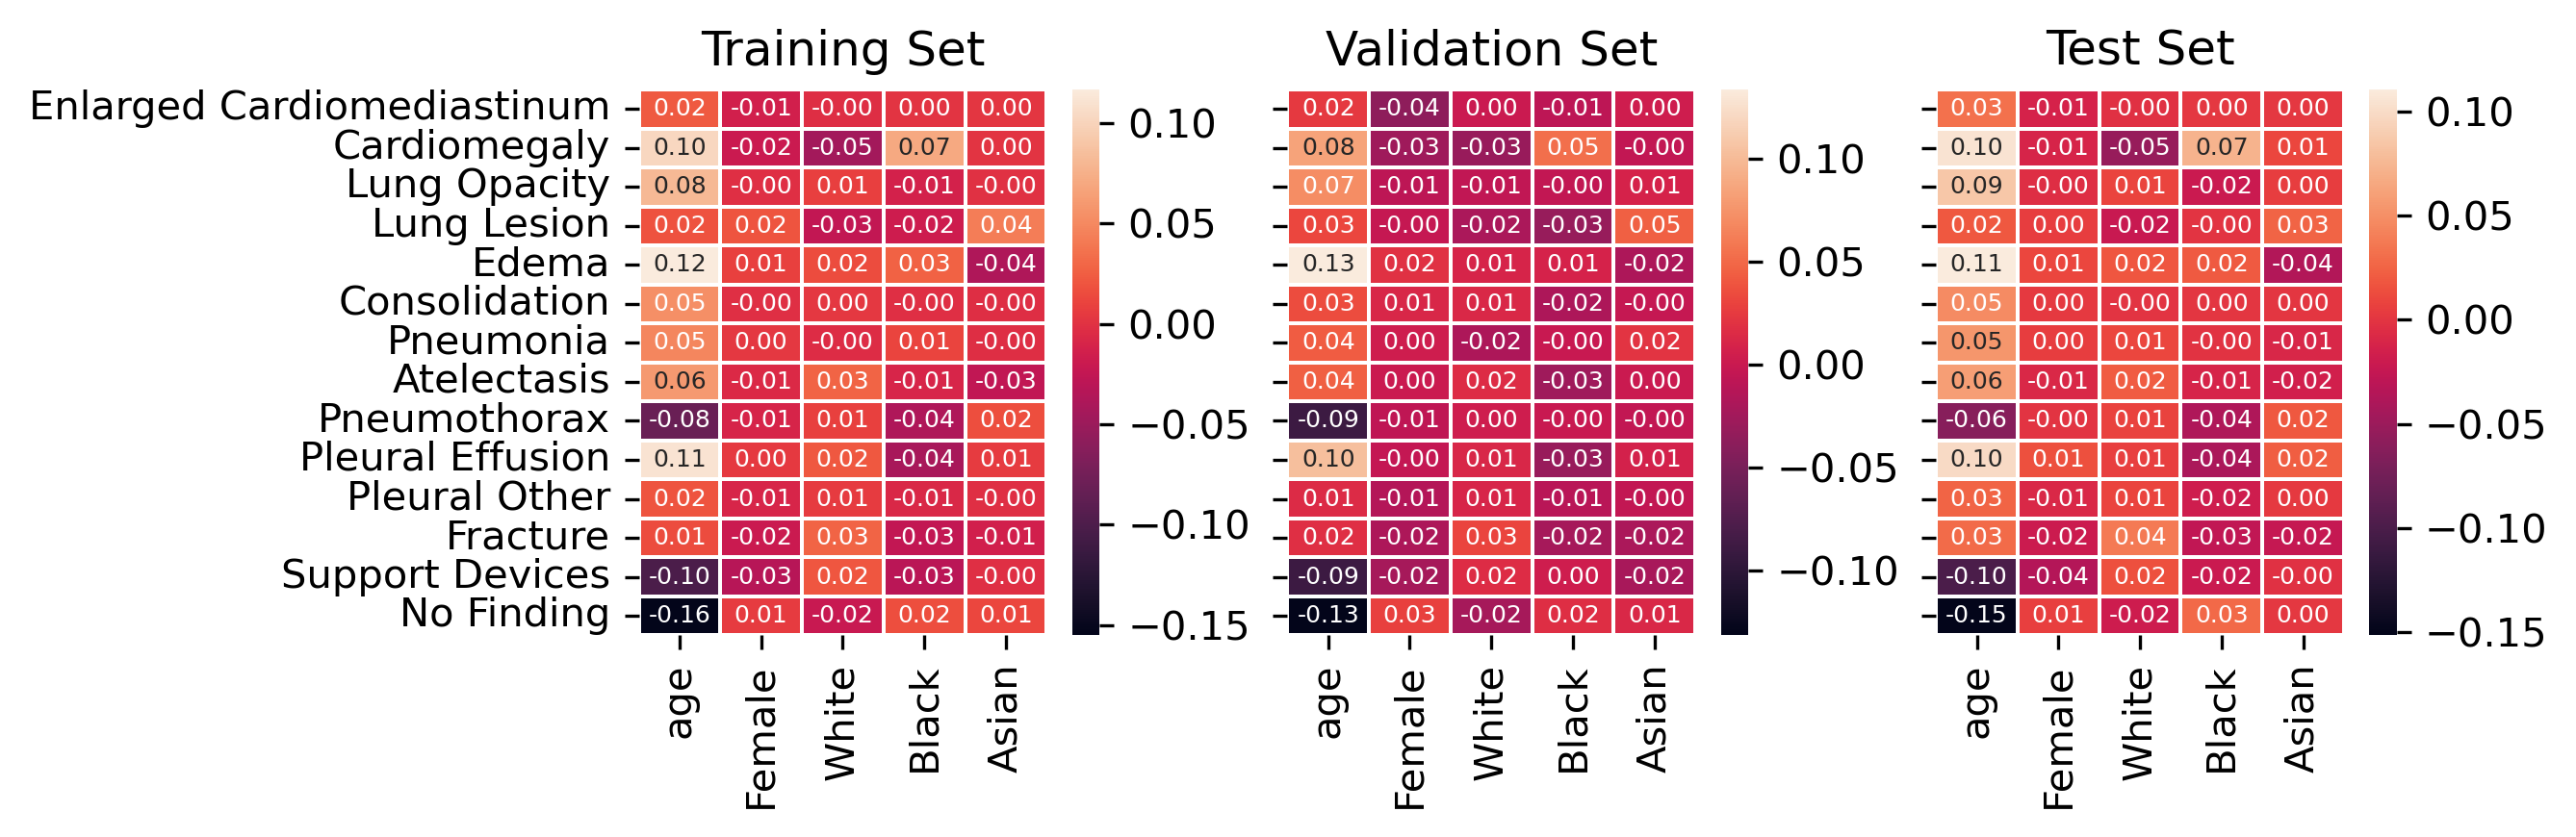

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharey=True, sharex=True, dpi=300)
df_names = ['Training Set', 'Validation Set', 'Test Set']

for idx, df in enumerate([df_train, df_val, df_test]):
   test = df.fillna(0) 
   test = test.replace(-1, 1) # Replace uncertain labels with positive labels

   sub_df = test[['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
         'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
         'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
         'Support Devices', 'No Finding', 'age', 'race', 'sex']]
   selected_df = pd.get_dummies(sub_df, columns=['race'], prefix='', prefix_sep='')
   selected_df = pd.get_dummies(selected_df, columns=['sex'], prefix='', prefix_sep='')

   correlation_matrix = selected_df.corr()
   correlation_matrix = correlation_matrix.loc[['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
                                            'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                                            'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
                                            'Support Devices', 'No Finding']]
   correlation_matrix = correlation_matrix[['age', 'Female', 'White', 'Black', 'Asian']]

   # Set up the matplotlib figure
   # Create a heatmap of the correlation matrix
   sns.heatmap(correlation_matrix, annot=True, fmt=".2f", annot_kws={"size": 6}, linewidths=.5, ax=ax[idx]) 
   ax[idx].set_title(df_names[idx])

plt.tight_layout()
plt.show()

In [29]:
correlation_matrix

,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
age,0.008884,0.103797,0.086276,0.010852,0.093496,-0.002427,0.007073,0.010951,-0.062838,0.089035,0.007979,0.030296,-0.099684,-0.151571
Female,-0.017816,-0.014673,-0.005102,0.003868,0.004687,0.001562,0.004693,-0.016715,0.003813,0.012415,-0.013273,-0.019859,-0.035728,0.005965
White,-0.005010,-0.056647,0.008887,-0.023026,0.016434,-0.009562,0.000534,0.020715,0.004482,0.005149,0.007559,0.038303,0.015372,-0.019185
Black,0.005731,0.074511,-0.021691,0.001005,0.015345,-0.000830,0.000493,-0.017871,-0.037849,-0.043790,-0.017605,-0.030079,-0.020987,0.028259
Asian,0.001675,0.011870,0.005414,0.026130,-0.030335,0.011758,-0.000982,-0.011163,0.022308,0.025853,0.003990,-0.022798,-0.002663,0.001820


# Pleural Effusion Statistics

In [39]:
df_cxr.loc[df_cxr['disease'] == 'Pleural Effusion', 'disease'] = 'Pleur. Eff.'
df_cxr.loc[df_cxr['disease'] == 'No Finding', 'disease'] = 'No Find.'

/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

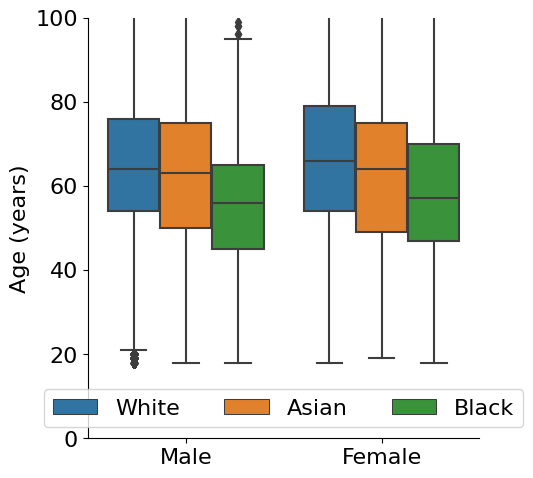

In [40]:
fontsize = 16
plt.rc('xtick', labelsize=fontsize) 
plt.rc('ytick', labelsize=fontsize)
fig = sns.catplot(x='sex', y='age', hue='race', order=['Male', 'Female'], hue_order=['White', 'Asian', 'Black'], kind="box", data=df_cxr)
fig._legend.remove()
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Age (years)', fontsize=fontsize)
plt.ylim([0, 100])
plt.legend(fontsize=fontsize, loc='lower center', ncol=3)
plt.show()

/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

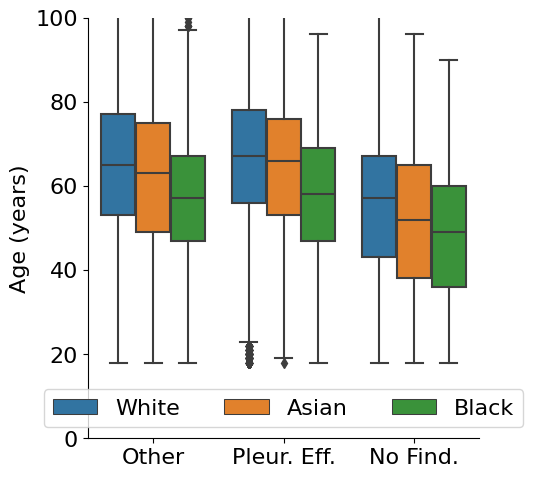

In [41]:
fig = sns.catplot(x='disease', y='age', hue='race', order=['Other', 'Pleur. Eff.', 'No Find.'], hue_order=['White', 'Asian', 'Black'], kind="box", data=df_cxr)
fig._legend.remove()
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Age (years)', fontsize=fontsize)
plt.ylim([0, 100])
plt.legend(fontsize=fontsize, loc='lower center', ncol=3)
plt.show()

/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

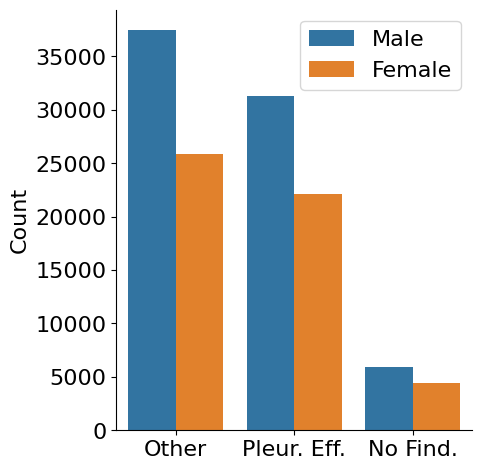

In [42]:
fig = sns.catplot(x='disease', hue='sex', order=['Other', 'Pleur. Eff.', 'No Find.'], hue_order=['Male', 'Female'], data=df_cxr, kind='count')
fig._legend.remove()
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

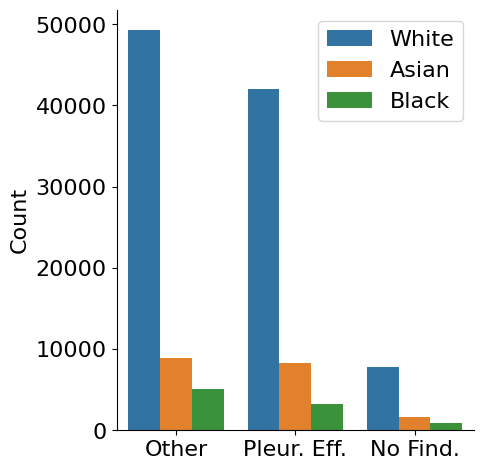

In [43]:
fig = sns.catplot(x='disease', hue='race', order=['Other', 'Pleur. Eff.', 'No Find.'], hue_order=['White', 'Asian', 'Black'], data=df_cxr, kind='count')
fig._legend.remove()
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aas926/miniconda3/envs/chexploration/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

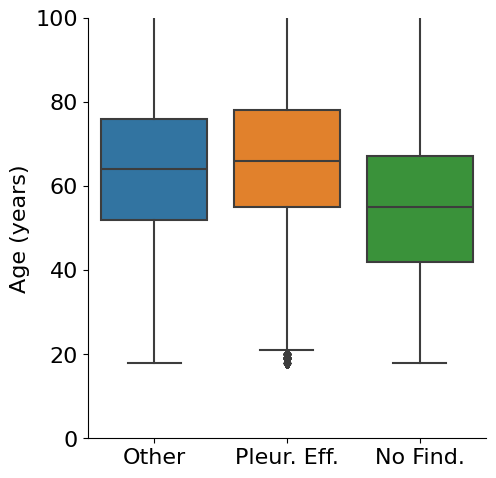

In [44]:
fig = sns.catplot(x='disease', y='age', order=['Other', 'Pleur. Eff.', 'No Find.'], kind="box", data=df_cxr)
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Age (years)', fontsize=fontsize)
plt.ylim([0, 100])
plt.show()